In [54]:
import time
start_time = time.time()
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import xml.etree.ElementTree as ET
import urllib
import re
import io
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.svm import SVR
import datetime
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.rnn import LSTM
from keras.models import Sequential
from math import sqrt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# be able to save images on server
matplotlib.use('Agg')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import Series
from keras.callbacks import EarlyStopping, TensorBoard

In [3]:
df_all = pd.read_csv('TotalTrafficDataSet.csv')

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262630 entries, 0 to 262629
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date_UTC          262630 non-null  object 
 1   ID                262630 non-null  object 
 2   TrafficIntensity  262630 non-null  float64
 3   TrafficSpeed      262630 non-null  float64
 4   TrafficOccupancy  262630 non-null  float64
dtypes: float64(3), object(2)
memory usage: 10.0+ MB


In [5]:
df_all.describe()

TrafficIntensity   TrafficSpeed  TrafficOccupancy
count     262630.000000  262630.000000     262630.000000
mean        1320.576334      73.334550          4.978633
std         1479.897294      22.281815          6.517470
min       -15109.664590    -114.049453       -178.255254
25%          272.066621      65.502021          1.000000
50%          805.053403      79.060525          3.353506
75%         1970.512178      87.000000          7.194232
max        26267.807690    1132.603181        103.673624

In [6]:
ID = 'PM20412'
df = df_all[df_all['ID'] == ID].reset_index(drop = True)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
df.drop('ID', axis=1, inplace= True)

In [9]:
df.head()

Date_UTC  TrafficIntensity  TrafficSpeed  TrafficOccupancy
0  2014-03-01 0:00       1140.000000     84.000000          3.000000
1  2014-03-01 0:05       1178.172453     82.026375          3.384921
2  2014-03-01 0:10       1253.737962     81.109989          3.730159
3  2014-03-01 0:15       1344.000000     81.000000          4.000000
4  2014-03-01 0:20       1426.262038     81.445567          4.158730

<AxesSubplot:>

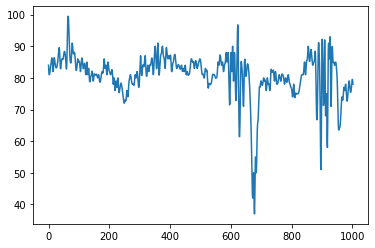

In [10]:
df['TrafficSpeed'].plot()

<AxesSubplot:>

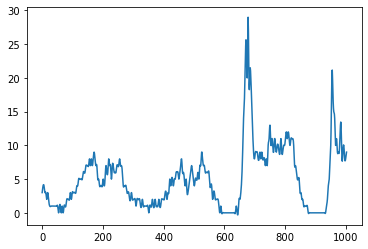

In [11]:
df['TrafficOccupancy'].plot()

<AxesSubplot:>

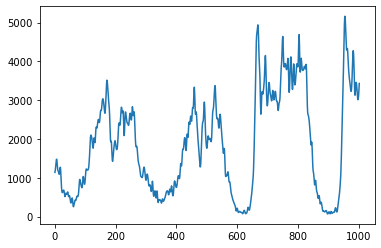

In [12]:
df['TrafficIntensity'].plot()

In [13]:
df.corr()

TrafficIntensity  TrafficSpeed  TrafficOccupancy
TrafficIntensity          1.000000     -0.470966          0.898313
TrafficSpeed             -0.470966      1.000000         -0.693894
TrafficOccupancy          0.898313     -0.693894          1.000000

<AxesSubplot:>

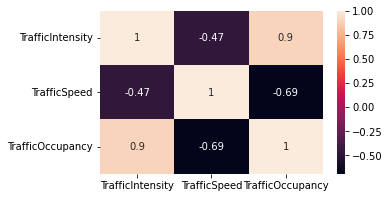

In [14]:
plt.figure(figsize=(5, 3))
sns.heatmap(df.corr(),annot=True)

In [15]:
# conct the data related to the other ids as features for the subject ID
def concat_ids(df):
    
    grouped_df = df_all.groupby('ID')

    unique_id_list = []

    frames = []
    frames.append(df)
    
    for name, group in grouped_df:

        if (group.shape[0] == len(df)) & (name != ID):
            unique_id_list.append(name)
            df_group = group[['TrafficSpeed', 'TrafficIntensity', 'TrafficOccupancy']].reset_index(drop=True)
            df_group.columns = ['TrafficSpeed' + '_' + str(name) , 'TrafficIntensity' + '_' + str(name) , 'TrafficOccupancy' + '_' + str(name)]
            frames.append(df_group)
    df_concatated = pd.concat(frames, axis=1)
    
    return df_concatated

In [16]:
df = concat_ids(df)

In [17]:
df.head()

Date_UTC  TrafficIntensity  TrafficSpeed  TrafficOccupancy  \
0  2014-03-01 0:00       1140.000000     84.000000          3.000000   
1  2014-03-01 0:05       1178.172453     82.026375          3.384921   
2  2014-03-01 0:10       1253.737962     81.109989          3.730159   
3  2014-03-01 0:15       1344.000000     81.000000          4.000000   
4  2014-03-01 0:20       1426.262038     81.445567          4.158730   

   TrafficSpeed_PM10001  TrafficIntensity_PM10001  TrafficOccupancy_PM10001  \
0             93.000000               1116.000000                  3.000000   
1             90.140827                930.315999                  3.470385   
2             87.779328                896.252800                  3.798531   
3             86.000000                960.000000                  4.000000   
4             84.887339               1067.747200                  4.090358   

   TrafficSpeed_PM10005  TrafficIntensity_PM10005  TrafficOccupancy_PM10005  \
0            101.000000                312.000000                  2.000000   
1             98.489534                326.355781                  1.778730   
2             96.924961                357.884625                  1.800762   
3             96.000000                396.000000                  2.000000   
4             95.408373                430.115375                  2.310349   

   ...  TrafficOccupancy_PM43152  TrafficSpeed_PM43201  \
0  ...                  0.000000             91.000000   
1  ...                  0.554031             92.607790   
2  ...                  0.865447             93.175121   
3  ...                  1.000000             93.000000   
4  ...                  1.023442             92.380435   

   TrafficIntensity_PM43201  TrafficOccupancy_PM43201  TrafficSpeed_PM43202  \
0                780.000000                  2.000000             74.000000   
1                773.304514                  1.210411             71.608223   
2                763.976945                  0.923885             77.019912   
3                756.000000                  1.000000             87.000000   
4                753.356388                  1.298338             98.313422   

   TrafficIntensity_PM43202  TrafficOccupancy_PM43202  TrafficSpeed_PM43221  \
0                 72.000000                  0.000000             92.000000   
1                 64.810067                 -0.254905             95.589769   
2                 70.248054                 -0.226146             95.494037   
3                 84.000000                  0.000000             93.000000   
4                101.751946                  0.337258             89.394852   

   TrafficIntensity_PM43221  TrafficOccupancy_PM43221  
0                780.000000                  3.000000  
1                601.512440                  2.630705  
2                588.676619                  2.682342  
3                684.000000                  3.000000  
4                829.990048                  3.428769  

[5 rows x 439 columns]

In [18]:
df['Date_UTC'] = pd.to_datetime(df.Date_UTC, format='%Y-%m-%d %H:%M:%S')

In [19]:
# setting Date and time column as an index
df= df.set_index('Date_UTC')

In [20]:
def timeseries_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [21]:
reframed = timeseries_to_supervised(df.values, 1, 1)

In [22]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var5(t-1)  var6(t-1)  \
1  1140.000000  84.000000   3.000000  93.000000  1116.000000   3.000000   
2  1178.172453  82.026375   3.384921  90.140827   930.315999   3.470385   
3  1253.737962  81.109989   3.730159  87.779328   896.252800   3.798531   
4  1344.000000  81.000000   4.000000  86.000000   960.000000   4.000000   
5  1426.262038  81.445567   4.158730  84.887339  1067.747200   4.090358   

    var7(t-1)   var8(t-1)  var9(t-1)  var10(t-1)  ...  var429(t)  var430(t)  \
1  101.000000  312.000000   2.000000   87.000000  ...   0.554031  92.607790   
2   98.489534  326.355781   1.778730   89.638268  ...   0.865447  93.175121   
3   96.924961  357.884625   1.800762   90.021725  ...   1.000000  93.000000   
4   96.000000  396.000000   2.000000   89.000000  ...   1.023442  92.380435   
5   95.408373  430.115375   2.310349   87.422719  ...   1.001524  91.614432   

    var431(t)  var432(t)   var433(t)   var434(t)  var435(t)  var436(t)  \
1  773.304514   1.210411   71.608223   64.810067  -0.254905  95.589769   
2  763.976945   0.923885   77.019912   70.248054  -0.226146  95.494037   
3  756.000000   1.000000   87.000000   84.000000   0.000000  93.000000   
4  753.356388   1.298338   98.313422  101.751946   0.337258  89.394852   
5  760.028819   1.678478  107.725111  119.189933   0.699350  85.965787   

    var437(t)  var438(t)  
1  601.512440   2.630705  
2  588.676619   2.682342  
3  684.000000   3.000000  
4  829.990048   3.428769  
5  969.154226   3.813739  

[5 rows x 876 columns]

In [23]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[440:876], axis=1, inplace=True)

In [24]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var5(t-1)  var6(t-1)  \
1  1140.000000  84.000000   3.000000  93.000000  1116.000000   3.000000   
2  1178.172453  82.026375   3.384921  90.140827   930.315999   3.470385   
3  1253.737962  81.109989   3.730159  87.779328   896.252800   3.798531   
4  1344.000000  81.000000   4.000000  86.000000   960.000000   4.000000   
5  1426.262038  81.445567   4.158730  84.887339  1067.747200   4.090358   

    var7(t-1)   var8(t-1)  var9(t-1)  var10(t-1)  ...  var431(t-1)  \
1  101.000000  312.000000   2.000000   87.000000  ...   780.000000   
2   98.489534  326.355781   1.778730   89.638268  ...   773.304514   
3   96.924961  357.884625   1.800762   90.021725  ...   763.976945   
4   96.000000  396.000000   2.000000   89.000000  ...   756.000000   
5   95.408373  430.115375   2.310349   87.422719  ...   753.356388   

   var432(t-1)  var433(t-1)  var434(t-1)  var435(t-1)  var436(t-1)  \
1     2.000000    74.000000    72.000000     0.000000    92.000000   
2     1.210411    71.608223    64.810067    -0.254905    95.589769   
3     0.923885    77.019912    70.248054    -0.226146    95.494037   
4     1.000000    87.000000    84.000000     0.000000    93.000000   
5     1.298338    98.313422   101.751946     0.337258    89.394852   

   var437(t-1)  var438(t-1)      var1(t)    var2(t)  
1   780.000000     3.000000  1178.172453  82.026375  
2   601.512440     2.630705  1253.737962  81.109989  
3   588.676619     2.682342  1344.000000  81.000000  
4   684.000000     3.000000  1426.262038  81.445567  
5   829.990048     3.428769  1477.827547  82.195847  

[5 rows x 440 columns]

In [25]:
def correlated_feat(df):
    
    last_var = df[df.columns[-2:]]
    #df = df.drop(columns=['var1(t)', 'var2(t)'], axis = 1)
    df = df.drop( ['var1(t)', 'var2(t)'] , axis = 1)
    
    frames = []
    for column in df:
        correlated_matrix1 = np.corrcoef(last_var.iloc[:, 0], df[column])
        correlated_matrix2 = np.corrcoef(last_var.iloc[:, 1], df[column])
        if (correlated_matrix1[0][1] >= abs(0.8) ) or (correlated_matrix2[0][1] >= abs(0.8)) or ((correlated_matrix1[0][1] > abs(0.1)) & (correlated_matrix2[0][1] > abs(0.1))) :
            frames.append(df[column])

    frames.append(last_var)
    correlated_df = pd.concat(frames, axis=1)
    
    return correlated_df

In [26]:
correlated_df = correlated_feat(reframed)

C:\Users\saeid\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\saeid\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [27]:
correlated_df.head()

var1(t-1)  var2(t-1)  var3(t-1)    var5(t-1)  var6(t-1)   var7(t-1)  \
1  1140.000000  84.000000   3.000000  1116.000000   3.000000  101.000000   
2  1178.172453  82.026375   3.384921   930.315999   3.470385   98.489534   
3  1253.737962  81.109989   3.730159   896.252800   3.798531   96.924961   
4  1344.000000  81.000000   4.000000   960.000000   4.000000   96.000000   
5  1426.262038  81.445567   4.158730  1067.747200   4.090358   95.408373   

    var8(t-1)  var11(t-1)  var17(t-1)   var20(t-1)  ...  var422(t-1)  \
1  312.000000  984.000000  204.000000  1164.000000  ...   156.000000   
2  326.355781  978.246342  103.532574  1192.586458  ...   167.755070   
3  357.884625  954.330407   80.692726  1263.135833  ...   180.604056   
4  396.000000  924.000000  108.000000  1356.000000  ...   192.000000   
5  430.115375  899.002926  157.973940  1451.530834  ...   199.395944   

   var425(t-1)  var426(t-1)  var428(t-1)  var431(t-1)  var434(t-1)  \
1  1116.000000     4.000000    36.000000   780.000000    72.000000   
2   994.352642     3.747786    65.725853   773.304514    64.810067   
3   965.615447     3.798229    75.247349   763.976945    70.248054   
4   996.000000     4.000000    72.000000   756.000000    84.000000   
5  1051.717887     4.201771    63.419318   753.356388   101.751946   

   var437(t-1)  var438(t-1)      var1(t)    var2(t)  
1   780.000000     3.000000  1178.172453  82.026375  
2   601.512440     2.630705  1253.737962  81.109989  
3   588.676619     2.682342  1344.000000  81.000000  
4   684.000000     3.000000  1426.262038  81.445567  
5   829.990048     3.428769  1477.827547  82.195847  

[5 rows x 248 columns]

In [28]:
# normalize features by scaling them in [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(correlated_df.values)

In [29]:
scaled.shape

(1002, 248)

In [30]:
scaled

array([[0.21019645, 0.75218519, 0.11291684, ..., 0.0967981 , 0.21768743,
        0.72059941],
       [0.21768743, 0.72059941, 0.12604981, ..., 0.08568707, 0.23251644,
        0.70593362],
       [0.23251644, 0.70593362, 0.13782884, ..., 0.08724067, 0.2502295 ,
        0.70417337],
       ...,
       [0.58697808, 0.67216549, 0.28350976, ..., 0.30740822, 0.60453038,
        0.68035927],
       [0.60453038, 0.68035927, 0.29616455, ..., 0.30774654, 0.6292784 ,
        0.67662852],
       [0.6292784 , 0.67662852, 0.30880563, ..., 0.30783112, 0.65997952,
        0.65616155]])

In [31]:
# split into train and test sets
n_train_size = round((2/3)*len(scaled))

train, test = scaled[0:-n_train_size], scaled[-n_train_size:]

#train = scaled[:n_train_size, :]
#test = scaled[n_train_size:, :]

# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]

In [32]:
def fit_lstm(train_X, train_y, test_X, test_y):
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    model = Sequential()
    # Stack LSTM
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(2))
    model.add(Activation("sigmoid"))
    
    model.compile(loss="mae", optimizer="adam")
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=0)
    iniCallBack = TensorBoard(log_dir='logs/initrain{}'.format(0), update_freq=12000)
    history = model.fit(train_X, train_y, batch_size=32, epochs=100, validation_split=0.2, shuffle=False)
    
    y_pred = model.predict(test_X)

    #model.save('my-model.h5')

    return model, history, y_pred

In [33]:
model, history, y_pred = fit_lstm(train_X, train_y, test_X, test_y)

(334, 1, 246) (334, 2) (668, 1, 246) (668, 2)
Epoch 1/100
9/9 [==============================] - 4s 81ms/step - loss: 0.1850 - val_loss: 0.1936
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1485 - val_loss: 0.1662
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1307 - val_loss: 0.1530
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1222 - val_loss: 0.1311
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1037 - val_loss: 0.1058
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0786 - val_loss: 0.0799
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0561 - val_loss: 0.0543
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0487 - val_loss: 0.0628
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0374
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0432 -

9/9 [==============================] - 0s 6ms/step - loss: 0.0282 - val_loss: 0.0384
Epoch 85/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0282 - val_loss: 0.0353
Epoch 86/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0311
Epoch 87/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0427
Epoch 88/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0336
Epoch 89/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0287 - val_loss: 0.0382
Epoch 90/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0248 - val_loss: 0.0317
Epoch 91/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0377
Epoch 92/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0347 - val_loss: 0.0414
Epoch 93/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0319
Epoch 94/100
9/9 [===============

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            138800    
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 219,402
Trainable params: 219,402
Non-trai

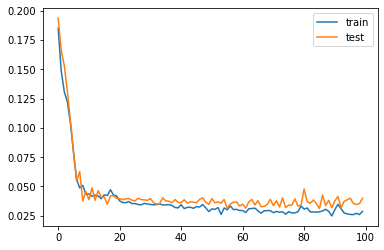

In [35]:
# visulizing the loss on the train set and the validation set
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [36]:
y_pred

array([[0.10855655, 0.78974515],
       [0.10669528, 0.79111826],
       [0.10458545, 0.79064864],
       ...,
       [0.5011326 , 0.6716322 ],
       [0.4909134 , 0.6778899 ],
       [0.49598193, 0.67581326]], dtype=float32)

In [37]:
def invert_scale(test_X, test_y, yhat, scaler):
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, :2]
    inv_yhat = inv_yhat.ravel()

    # invert scaling for actual
    inv_y = np.concatenate((test_y, test_X), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, :2]
    inv_y = inv_y.ravel()

    return inv_y, inv_yhat

In [38]:
inv_y, inv_yhat = invert_scale(test_X, test_y, y_pred, scaler)

In [46]:
pred_speed =[]
pred_intensity =[]

act_speed =[]
act_intensity =[]

for i , x in enumerate(inv_yhat):
    if (i % 2)==1 :
        pred_speed.append(x)
    else:
        pred_intensity.append(x)

for i , x in enumerate(inv_y):
    if (i % 2)==1 :
        act_speed.append(x)
    else:
        act_intensity.append(x)

In [56]:
rmse_speed = mean_absolute_percentage_error(act_speed, pred_speed)
rmse_intensity = mean_absolute_percentage_error(act_intensity, pred_intensity)

print('Speed MAPE is: %.3f' % rmse_speed)
print('Speed MAPE is: %.3f' % rmse_intensity)

Speed MAPE is: 0.066
Speed MAPE is: 0.805


C:\Users\saeid\AppData\Local\Temp\ipykernel_25912\4239749264.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


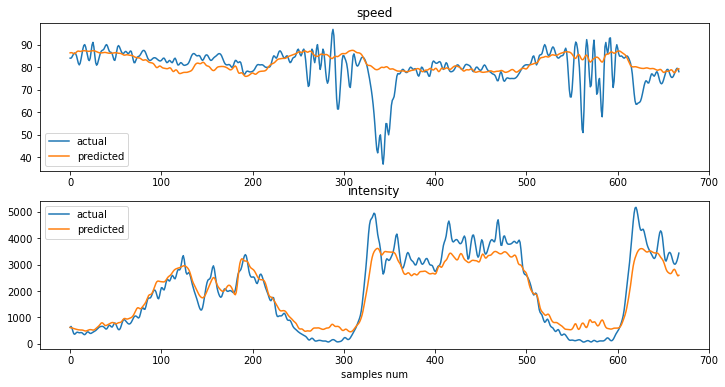

In [58]:
    plt.figure(figsize=(12,6))
    plt.subplot(2, 1, 1)
    plt.plot(act_speed)
    plt.plot(pred_speed)
    plt.title('speed')
    plt.legend(['actual', 'predicted'])

    plt.subplot(2, 1, 2)
    plt.plot(act_intensity)
    plt.plot(pred_intensity)
    plt.title('intensity')
    plt.legend(['actual', 'predicted'])

    plt.xlabel('samples num')

    plt.show()